# landscape Images Classification

<font color="purple">As a result of saving in a PDF file, there were disturbances in the font sizes.<br>
For more convenient viewing, you can enter the following github link: https://github.com/Esther-Bi/Machine-Learning-Course-semA/blob/main/lemidat%20mechona%20-%20After%20comments%20and%20changes.ipynb</font>

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import cv2
from os import listdir
from os.path import isfile, join

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Dimension reduction
from skimage.measure import block_reduce
from skimage import io
from sklearn.cluster import KMeans

# Scailing
from sklearn.preprocessing import StandardScaler

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

### Our Functions:

In [2]:
def readImg_convert2gray_resize(file_path):
    img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (32,32))
    return resized_img

In [5]:
def readImg_convert2RGB_resize(file_path):
    img = cv2.imread(file_path)
    colored_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(colored_img, (150,150))
    return resized_img

In [3]:
def img2array_addLabel_gray(name, label):    
    imgSize = 32*32
    folder = 'C:/Users/97254/Desktop/archive/seg_train/seg_train/'
    onlyFiles = [f for f in listdir(folder + name) if isfile(join(folder + name, f))]
    
    X = np.ndarray((len(onlyFiles),imgSize), dtype=np.uint8)
    y = np.zeros((len(onlyFiles),1))
    
    for i in range(len(onlyFiles)):
        img = readImg_convert2gray_resize(folder + name + '/' + onlyFiles[i])
        X[i,:] = img.ravel()
        y[i,0] = label
    return X,y

In [6]:
def img2array_addLabel_RGB(name, label):    
    imgSize = 150*150*3
    folder = 'C:/Users/97254/Desktop/archive/seg_train/seg_train/'
    onlyFiles = [f for f in listdir(folder + name) if isfile(join(folder + name, f))]
    
    X = np.ndarray((len(onlyFiles),imgSize), dtype=np.uint8)
    y = np.zeros((len(onlyFiles),1))
    
    for i in range(len(onlyFiles)):
        img = readImg_convert2RGB_resize(folder + name + '/' + onlyFiles[i])
        X[i,:] = img.ravel()
        y[i,0] = label
    return X,y

In [4]:
def build_gray_data_set():
    X0,y0 = img2array_addLabel_gray('buildings',0)
    buildings_df = pd.DataFrame(X0)
    buildings_df['label'] = y0 # adding a column that expresses the label
    
    X1,y1 = img2array_addLabel_gray('forest',1)
    forest_df = pd.DataFrame(X1)
    forest_df['label'] = y1 # adding a column that expresses the label

    X2,y2 = img2array_addLabel_gray('glacier',2)
    glacier_df = pd.DataFrame(X2)
    glacier_df['label'] = y2 # adding a column that expresses the label

    X3,y3 = img2array_addLabel_gray('mountain',3)
    mountain_df = pd.DataFrame(X3)
    mountain_df['label'] = y3 # adding a column that expresses the label

    X4,y4 = img2array_addLabel_gray('sea',4)
    sea_df = pd.DataFrame(X4)
    sea_df['label'] = y4 # adding a column that expresses the label

    X5,y5 = img2array_addLabel_gray('street',5)
    street_df = pd.DataFrame(X5)
    street_df['label'] = y5 # adding a column that expresses the label

    df = pd.concat([buildings_df, forest_df, glacier_df, mountain_df, sea_df, street_df])
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [7]:
def build_RGB_data_set():
    X0,y0 = img2array_addLabel_RGB('buildings',0)
    buildings_df = pd.DataFrame(X0)
    buildings_df['label'] = y0 # adding a column that expresses the label
    
    X1,y1 = img2array_addLabel_RGB('forest',1)
    forest_df = pd.DataFrame(X1)
    forest_df['label'] = y1 # adding a column that expresses the label

    X2,y2 = img2array_addLabel_RGB('glacier',2)
    glacier_df = pd.DataFrame(X2)
    glacier_df['label'] = y2 # adding a column that expresses the label

    X3,y3 = img2array_addLabel_RGB('mountain',3)
    mountain_df = pd.DataFrame(X3)
    mountain_df['label'] = y3 # adding a column that expresses the label

    X4,y4 = img2array_addLabel_RGB('sea',4)
    sea_df = pd.DataFrame(X4)
    sea_df['label'] = y4 # adding a column that expresses the label

    X5,y5 = img2array_addLabel_RGB('street',5)
    street_df = pd.DataFrame(X5)
    street_df['label'] = y5 # adding a column that expresses the label

    df = pd.concat([buildings_df, forest_df, glacier_df, mountain_df, sea_df, street_df])
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [32]:
def avg_pool(df):

    without_label_df = df.drop(['label'], axis =1).to_numpy()
    labels = df.label

    img = without_label_df[0].reshape(150,150,3)
    mean_pool = block_reduce(img, block_size=(5,5,1), func=np.mean)
    ravel_img = mean_pool.astype('uint8').ravel()
    columns=list(range(2700))

    mean_pool_df = pd.DataFrame(np.atleast_2d(ravel_img), columns=columns)

    for i in range(1,len(df)):
        img = without_label_df[i].reshape(150,150,3)
        mean_pool = block_reduce(img, block_size=(5,5,1), func=np.mean)
        ravel_img = mean_pool.astype('uint8').ravel()
        mean_pool_df.loc[i] = ravel_img
    
    return mean_pool_df.join(labels)

In [71]:
def reduce_plt(df):

    without_label_df = df.drop(['label'], axis =1)
    without_label_np = without_label_df.to_numpy()
    my_labels = df.label
    n_colors = 10

    for i in range(len(df)):
        img = without_label_np[i].reshape(30,30,3)
        
        arr = img.reshape((-1, 3))
        kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        less_colors = centers[labels].reshape(img.shape)
        
        ravel_img = less_colors.astype('uint8').ravel()
        without_label_df.loc[i] = ravel_img
    
    return without_label_df.join(my_labels)

In [15]:
results={}

def HetmapAndConf(model , X_train , y_train , X_test, y_test):
    #training the model
    model.fit(X_train,y_train)
    #model prediction
    y_pred = model.predict(X_test)
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=True , cmap="BuPu", linewidths=1, fmt = 'd')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    # add accuracy score to 'results'
    results[model]=metrics.accuracy_score(y_test, y_pred)
    # evaluating the model
    print("Training Accuracy :", model.score(X_train, y_train))
    print("Testing Accuracy :" , metrics.accuracy_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))

##### About the classification problem:
The data consists of landscape images that are classified into 6 types:
* buildings
* forests
* glaciers
* mountains
* sea
* streets

### Our Process:
1. Uploading the images in their original size, 150 * 150 * 3
2. Conversion from BGR to RGB
3. Running PCA with a value of 2028 to refine the important pixels in the image
4. Activating Average Pooling on each image to reduce dimensions
6. Reducing the number of shades present in each image from 256 to 10
5. Flattening the three matrices into a single vector and saving in a data frame

In [8]:
df_color = build_RGB_data_set()

In [9]:
df_color

,0,1,2,3,4,5,6,7,8,9,...,67491,67492,67493,67494,67495,67496,67497,67498,67499,label
0,159,109,134,161,111,136,163,115,139,166,...,219,209,220,146,136,147,123,113,124,4.0
1,28,21,28,28,21,28,29,22,29,30,...,96,71,40,124,99,68,90,65,34,0.0
2,170,174,183,171,175,184,173,177,186,174,...,186,166,133,183,163,130,174,154,121,0.0
3,47,126,218,47,126,218,47,126,218,48,...,23,22,27,77,78,83,51,52,57,3.0
4,30,127,170,29,126,169,27,125,170,26,...,0,23,54,0,19,52,4,22,58,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,74,134,196,74,134,196,74,134,196,75,...,79,123,162,57,99,137,64,106,144,2.0
14030,0,0,0,0,0,0,0,0,0,0,...,24,24,24,36,36,36,29,29,29,5.0
14031,199,215,230,200,216,231,201,217,230,202,...,16,25,32,13,22,31,18,27,36,2.0
14032,158,130,57,163,134,66,123,90,36,191,...,59,55,52,62,59,54,60,57,52,5.0


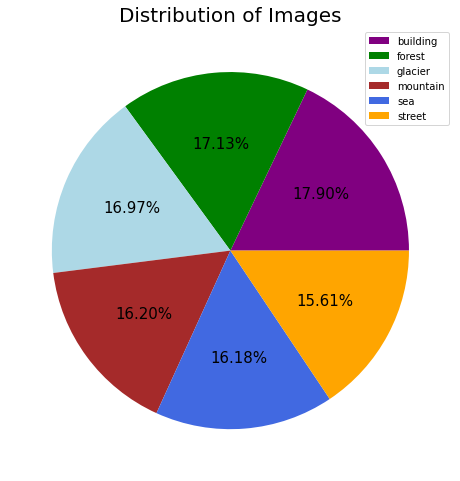

In [110]:
label = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
sorted_df = df.sort_values(by=['label'])
plt.subplots(figsize=(8, 9))
plt.pie(sorted_df['label'].value_counts(), colors = ['purple','green', 'lightblue', 'brown', 'royalblue', 'orange'], autopct = '%.2f%%' , textprops={"fontsize":15})
plt.title('Distribution of Images' , fontdict = {'fontsize' : 20})
plt.legend(label , loc=1)

plt.show()

As we can see in the distribution above, the data is balanced.

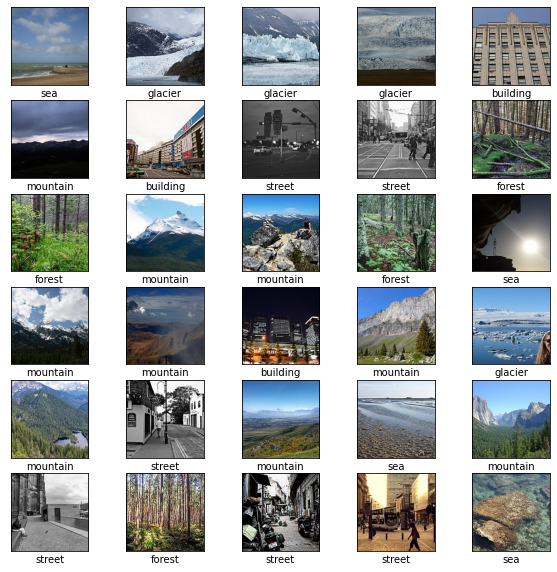

In [50]:
# Meaning of each label
label = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Scailing by dividing all in 255
input_data = df_color.drop(['label'],axis=1).to_numpy()
target = df_color[['label']].iloc[:, :]
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(input_data[i].reshape(150,150,3)) #cmap=plt.cm.binary
    plt.xlabel(label[int(target.label.iloc[i])])

In [79]:
df_color.to_csv('C:/Users/97254/Desktop/df_color.csv', index=False)

In the initial meeting with the data, we raised the following questions:
* Will most of the confusion be between glaciers and mountains? Will there be any confusion between other types of landscapes?
* Will there be good accuracy without using neural networks?
* Since this is a multi-class problem, is there a specific category that the models will fail to identify?

#### PCA:
Since our dataset includes images and therefore consists of many features, we decided to reduce dimensions in order to be able to run the models in the most efficient way.
The first way we used is PCA.

PCA is a technique for analyzing large datasets containing a high number of features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. Formally, PCA is a statistical technique for reducing the dimensionality of a dataset.

In order to choose the *n_components* value, we looked for what the chosen value would be using the following graph.

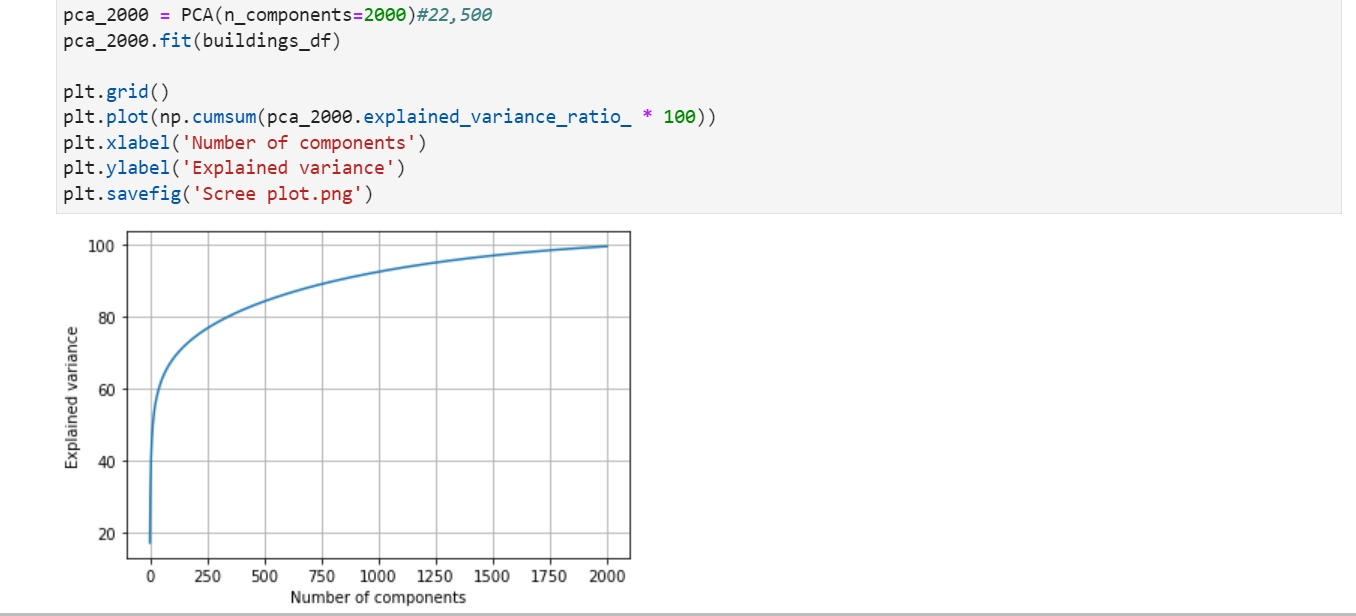

It can be seen that starting from 2000 pixels there is no significant change on the image, so we chose *n_components=2028* in order for it to be divided in an appropriate way to maintain an image shape.

In [43]:
pca_2028 = PCA(n_components=2028)
color_df_pca_2028_reduced = pca_2028.fit_transform(df_color.drop(['label'], axis =1))
color_df_pca_2028_recovered = pca_2028.inverse_transform(color_df_pca_2028_reduced)

In [45]:
labels = df_color.label
recovered = pd.DataFrame(color_df_pca_2028_recovered)
recovered = recovered.join(labels)
recovered

,0,1,2,3,4,5,6,7,8,9,...,67491,67492,67493,67494,67495,67496,67497,67498,67499,label
0,98.222203,118.423118,145.727864,92.584521,113.037373,141.260034,94.398493,115.625601,145.086820,97.886818,...,124.501705,102.695901,74.764900,118.333362,96.474451,69.358352,124.717811,103.021809,75.624188,4.0
1,139.619167,155.135212,171.806496,138.693322,154.688225,171.981281,120.632675,135.402066,156.872181,134.701827,...,38.351246,46.684805,54.693114,41.435927,48.821626,56.884489,58.092852,65.005917,71.193334,2.0
2,127.587753,145.531808,169.173876,131.447925,150.284021,173.703482,135.725074,155.380603,175.810409,125.657583,...,116.532042,141.160335,149.139455,111.043357,136.657016,144.696749,98.206688,124.275790,133.784027,2.0
3,120.928484,130.976707,141.428478,111.796471,122.386297,132.250996,106.761202,117.858826,129.565108,99.253011,...,41.256393,29.988959,9.533183,36.082525,24.710332,4.431310,46.556391,35.993792,15.326996,2.0
4,121.294401,134.211309,166.899133,112.948273,126.515556,160.039016,121.304279,136.744643,169.086499,108.599317,...,158.419535,148.849521,138.478038,142.884156,132.489307,122.953817,134.639682,125.221876,113.591771,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,219.662869,221.277624,217.166932,224.423852,226.040110,220.574025,236.362804,238.255405,232.483971,241.525401,...,24.223369,29.671820,37.457283,23.032309,28.259043,35.699683,25.728982,30.803478,38.456796,4.0
14030,149.548023,147.547162,149.508908,115.252640,113.595979,120.051239,112.906764,110.449169,120.519963,100.994000,...,91.016344,92.733703,89.218499,90.931956,94.891618,91.944415,75.880927,81.546866,79.704365,0.0
14031,117.008069,120.607481,153.161827,130.409547,133.987984,166.640124,131.104582,134.683233,168.224539,130.113196,...,92.852344,98.870549,119.389936,100.587524,106.397753,125.923511,99.488727,105.260344,124.584337,2.0
14032,215.432274,234.088377,254.549957,209.623041,228.278488,248.865084,215.982129,232.563491,256.305323,225.596353,...,51.832157,44.377698,38.786808,41.802418,35.123044,27.212820,35.469668,30.181661,18.098239,0.0


#### Average Pooling:
To reduce dimensions we used Pooling, that is, transferring a kernel of a certain size and performing a min\max\avg operation, in order to reduce any number of pixels together.

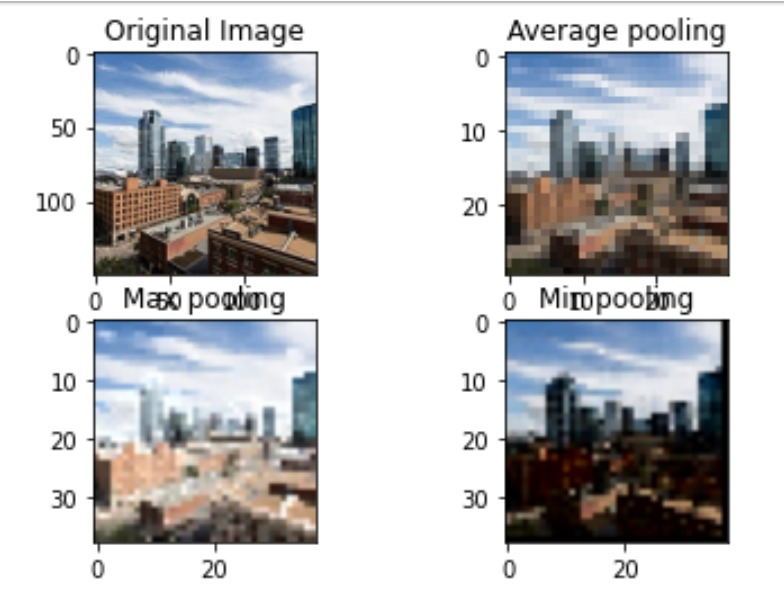

The best result for loosing the less data we can is average pooling and so we choose to use it.

In [46]:
pca_avg_pool = avg_pool(recovered)
pca_avg_pool

,0,1,2,3,4,5,6,7,8,9,...,2691,2692,2693,2694,2695,2696,2697,2698,2699,label
0,94,115,144,93,115,144,90,112,145,87,...,119,96,70,117,94,67,119,98,69,4.0
1,137,152,171,145,159,182,142,155,182,147,...,74,80,91,54,60,74,36,43,54,2.0
2,115,135,157,133,151,175,138,155,181,140,...,111,134,145,119,140,149,114,137,146,2.0
3,127,138,151,129,140,155,119,131,146,112,...,36,26,8,38,27,9,39,29,11,2.0
4,122,139,175,129,143,187,113,131,185,118,...,154,151,132,164,159,146,125,120,109,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,221,223,218,244,246,240,248,251,247,249,...,20,27,37,27,34,43,31,38,46,4.0
14030,143,140,147,148,146,146,189,183,183,199,...,66,69,68,70,74,73,74,77,76,0.0
14031,119,122,154,138,140,173,179,181,214,209,...,97,101,122,96,102,122,96,102,122,2.0
14032,197,211,233,196,211,240,222,238,2,219,...,14,13,5,39,36,26,52,47,37,0.0


In [52]:
pca_avg_pool.to_csv('C:/Users/97254/Desktop/pca_avg_pool.csv', index=False)

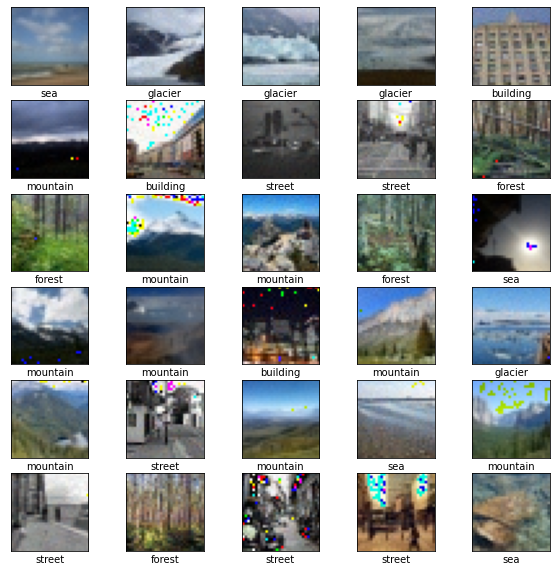

In [55]:
# Meaning of each label
label = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Scailing by dividing all in 255
input_data = pca_avg_pool.drop(['label'],axis=1).to_numpy()
target = pca_avg_pool[['label']].iloc[:, :]
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(input_data[i].reshape(30,30,3)) #cmap=plt.cm.binary
    plt.xlabel(label[int(target.label.iloc[i])])

#### Color Palette Reduction:
After reducing the dimensions, to make the models easier, we reduced the range of shades from *256* to *10* shades in total in each image.

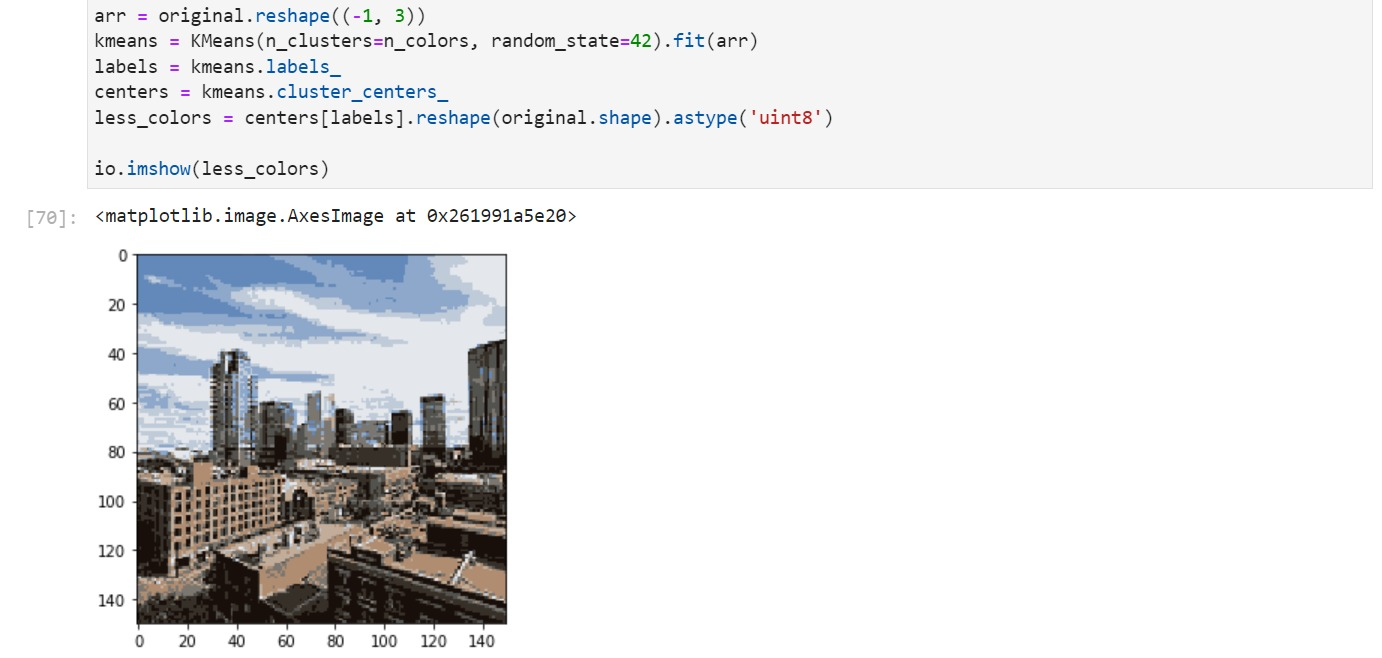

In [75]:
reduced_df = reduce_plt(pca_avg_pool)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,2691,2692,2693,2694,2695,2696,2697,2698,2699,label
0,83,111,151,83,111,151,83,111,151,83,...,113,98,76,113,98,76,113,98,76,4.0
1,136,147,163,155,166,184,155,166,184,155,...,80,89,105,57,64,80,41,46,59,2.0
2,117,132,152,139,156,172,139,156,172,139,...,117,132,152,117,132,152,117,132,152,2.0
3,132,142,148,132,142,148,121,132,138,106,...,37,28,12,37,28,12,37,28,12,2.0
4,113,134,173,113,134,173,113,134,173,113,...,161,151,137,171,162,148,122,116,107,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,242,240,235,242,240,235,242,240,235,242,...,11,39,64,11,39,64,11,39,64,4.0
14030,148,148,148,148,148,148,190,190,189,190,...,72,72,73,72,72,73,72,72,73,0.0
14031,124,125,148,138,139,164,179,184,218,179,...,100,102,127,100,102,127,100,102,127,2.0
14032,187,211,239,187,211,239,219,235,2,187,...,39,44,52,39,44,52,39,44,52,0.0


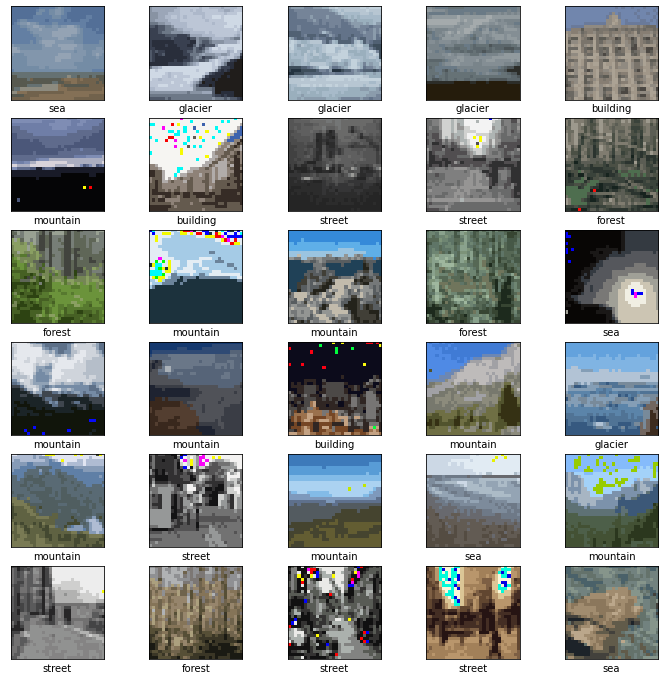

In [76]:
# Meaning of each label
label = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Scailing by dividing all in 255
input_data = reduced_df.drop(['label'],axis=1).to_numpy()
target = reduced_df[['label']].iloc[:, :]
# Set the figure size
plt.figure(figsize=(12,12))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(input_data[i].reshape(30,30,3)) #cmap=plt.cm.binary
    plt.xlabel(label[int(target.label.iloc[i])])

In [77]:
reduced_df.to_csv('C:/Users/97254/Desktop/pca_avg_pool_reduce.csv', index=False)

### Modelling:

In [81]:
X = reduced_df.drop('label', axis=1)
y = reduced_df.label

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#### First Model - K Neighbors Classifier

In [82]:
k_range = list(range(1, 13, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

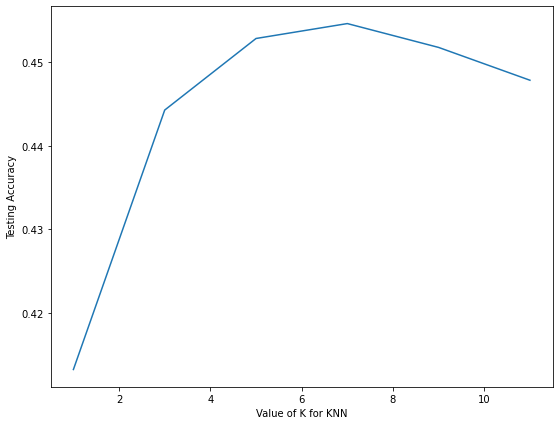

In [83]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

The best accuracy is with using *k=7* and so this is what we chosen.

Training Accuracy : 0.5351385053887948
Testing Accuracy : 0.45457784111150695

              precision    recall  f1-score   support

         0.0       0.51      0.04      0.08       453
         1.0       0.50      0.85      0.63       478
         2.0       0.53      0.51      0.51       477
         3.0       0.41      0.74      0.53       474
         4.0       0.31      0.40      0.35       424
         5.0       0.87      0.18      0.30       501

    accuracy                           0.45      2807
   macro avg       0.52      0.45      0.40      2807
weighted avg       0.53      0.45      0.40      2807



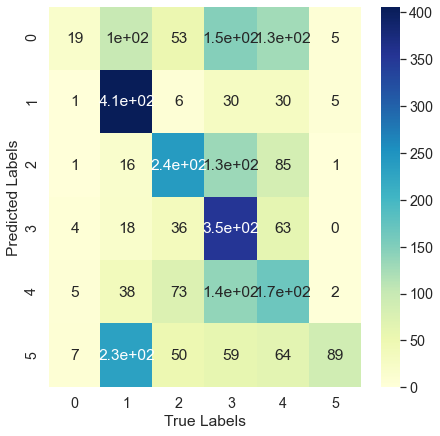

In [86]:
HetmapAndConf(KNeighborsClassifier(n_neighbors=7) , X_train , y_train , X_test, y_test)

<font color='red'>The biggest mistake is in buildings that were classified into forest, mountain and sea, and in streets that were classified almost directly into forest.<br>
It can be understood that streets are very similar to buildings because they are built from them, and so it is not very suprising.<br>
It is suprising that buildings are classified to mountains and sea, but sea is also classsified into mountains so it looks like there is a mistake in understanding what a sea is.<br>
Glacier has a misunderstanding with mountain which is what we were expecting.</font>
<br><br>
The accuracy is not high, so we tried the same model on the same data only in black and white tones.

In [5]:
df_gray = build_gray_data_set()

In [6]:
df_gray

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,175,171,173,173,175,179,177,176,176,177,...,52,48,5,214,231,212,215,229,235,3.0
1,33,33,35,35,36,37,38,39,40,42,...,69,66,74,64,80,84,77,95,125,4.0
2,120,119,121,121,121,122,121,122,122,122,...,41,38,37,35,39,40,44,40,48,4.0
3,46,70,36,32,56,39,102,90,41,92,...,74,74,76,81,80,88,87,82,82,5.0
4,219,220,225,229,232,235,234,236,234,236,...,43,4,17,6,7,4,23,9,32,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,139,137,154,158,138,126,186,153,171,186,...,216,168,96,110,101,138,99,91,97,1.0
14030,115,115,115,116,116,117,118,118,119,120,...,106,26,109,127,172,126,178,169,116,4.0
14031,96,95,96,96,96,97,97,97,101,102,...,58,31,42,39,25,105,59,19,21,3.0
14032,136,127,125,157,132,117,12,134,105,154,...,223,223,222,224,222,222,222,221,220,5.0


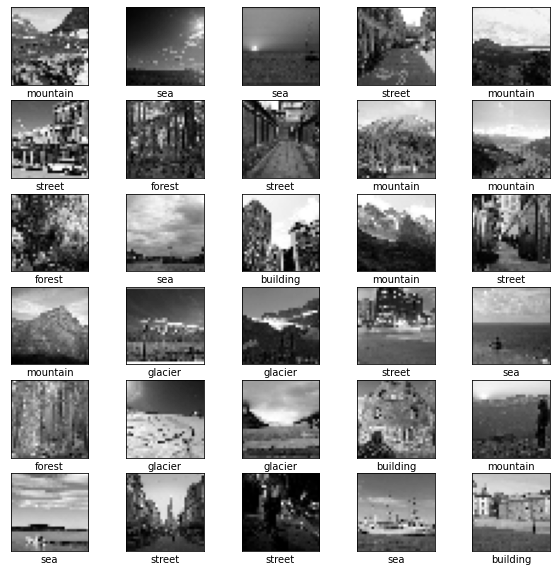

In [11]:
# Meaning of each label
label = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Scailing by dividing all in 255
input_data = df_gray.drop(['label'],axis=1).to_numpy()
target = df_gray[['label']].iloc[:, :]
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(input_data[i].reshape(32,32) , cmap="gray") 
    plt.xlabel(label[int(target.label.iloc[i])])

In [12]:
X_gray = df_gray.drop('label', axis=1)
y_gray = df_gray.label

# split the data into train and test sets
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gray, y_gray, test_size=0.2, random_state=4)

In [13]:
#scaling
sc = StandardScaler()
sc.fit(X_train_g)
X_train_g_std = sc.transform(X_train_g)
X_test_g_std = sc.transform(X_test_g)

Training Accuracy : 0.3788189186781865
Testing Accuracy : 0.2988956180976131

              precision    recall  f1-score   support

         0.0       0.56      0.03      0.06       437
         1.0       0.40      0.16      0.23       459
         2.0       0.36      0.29      0.32       476
         3.0       0.32      0.70      0.44       489
         4.0       0.19      0.47      0.27       440
         5.0       0.89      0.13      0.22       506

    accuracy                           0.30      2807
   macro avg       0.45      0.30      0.26      2807
weighted avg       0.46      0.30      0.26      2807



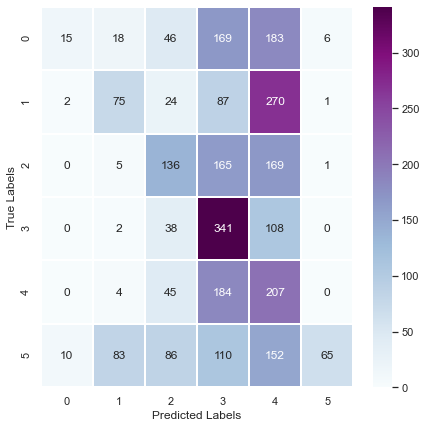

In [19]:
HetmapAndConf(KNeighborsClassifier(n_neighbors=7) , X_train_g_std , y_train_g , X_test_g_std, y_test_g)

In our opinion, the colors add a wide meaning to the images since the similar lines between images of the same class are the colors.
For example preventing confusion between glaciers and mountains would probably be based on their different colors.<br>
<br>
The pictures became very similar due to the lack of colors and blurring.<br>
We can assume that most of the images have sky and therefore the classification according to this was similar, beyond that the data became much less separated and therefore that is where the problem fell.

#### Second Model - Logistic Regression

In [101]:
#scaling
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

We started with a very high number of iterations, in the end we saw overfitting, so we started reducing the number of iterations until the desired result.

Training Accuracy : 0.8912443217244144
Testing Accuracy : 0.3940149625935162

              precision    recall  f1-score   support

         0.0       0.25      0.21      0.22       453
         1.0       0.61      0.65      0.63       478
         2.0       0.42      0.44      0.43       477
         3.0       0.36      0.39      0.38       474
         4.0       0.26      0.30      0.28       424
         5.0       0.42      0.35      0.39       501

    accuracy                           0.39      2807
   macro avg       0.39      0.39      0.39      2807
weighted avg       0.39      0.39      0.39      2807



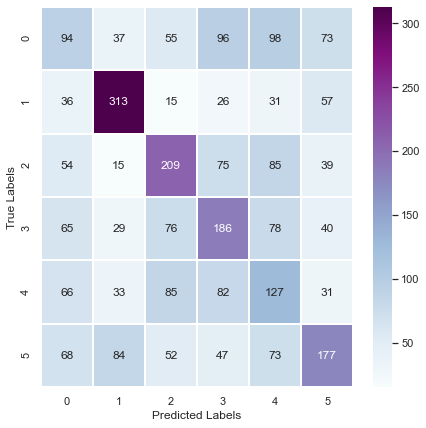

In [108]:
HetmapAndConf(LogisticRegression(max_iter=1000) , X_train_std , y_train , X_test_std, y_test)

Training Accuracy : 0.8772601763605594
Testing Accuracy : 0.4050587816173851

              precision    recall  f1-score   support

         0.0       0.24      0.20      0.22       453
         1.0       0.65      0.66      0.65       478
         2.0       0.44      0.47      0.45       477
         3.0       0.38      0.40      0.39       474
         4.0       0.26      0.31      0.28       424
         5.0       0.42      0.37      0.40       501

    accuracy                           0.41      2807
   macro avg       0.40      0.40      0.40      2807
weighted avg       0.40      0.41      0.40      2807



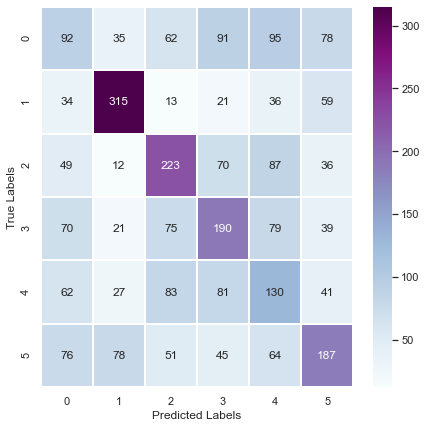

In [102]:
HetmapAndConf(LogisticRegression(max_iter=500) , X_train_std , y_train , X_test_std, y_test)

Training Accuracy : 0.7321635343368664
Testing Accuracy : 0.4470965443534022

              precision    recall  f1-score   support

         0.0       0.26      0.21      0.23       453
         1.0       0.71      0.69      0.70       478
         2.0       0.47      0.50      0.49       477
         3.0       0.42      0.46      0.44       474
         4.0       0.26      0.28      0.27       424
         5.0       0.52      0.50      0.51       501

    accuracy                           0.45      2807
   macro avg       0.44      0.44      0.44      2807
weighted avg       0.45      0.45      0.45      2807



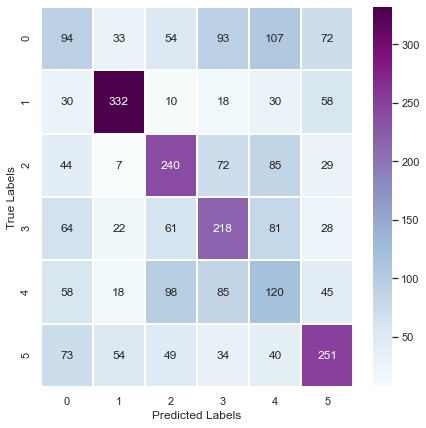

In [103]:
HetmapAndConf(LogisticRegression(max_iter=100) , X_train_std , y_train , X_test_std, y_test)

Training Accuracy : 0.7033936047029482
Testing Accuracy : 0.4666904168151051

              precision    recall  f1-score   support

         0.0       0.31      0.25      0.27       453
         1.0       0.75      0.71      0.73       478
         2.0       0.48      0.49      0.48       477
         3.0       0.45      0.48      0.47       474
         4.0       0.25      0.31      0.28       424
         5.0       0.55      0.53      0.54       501

    accuracy                           0.47      2807
   macro avg       0.47      0.46      0.46      2807
weighted avg       0.47      0.47      0.47      2807



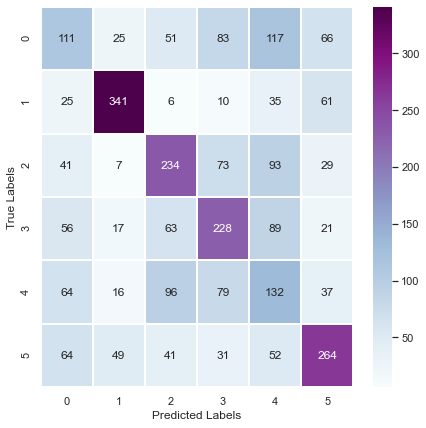

In [104]:
HetmapAndConf(LogisticRegression(max_iter=70) , X_train_std , y_train , X_test_std, y_test)

Training Accuracy : 0.6360559365814554
Testing Accuracy : 0.5012468827930174

              precision    recall  f1-score   support

         0.0       0.35      0.27      0.30       453
         1.0       0.73      0.76      0.75       478
         2.0       0.51      0.57      0.54       477
         3.0       0.47      0.50      0.49       474
         4.0       0.31      0.31      0.31       424
         5.0       0.55      0.56      0.56       501

    accuracy                           0.50      2807
   macro avg       0.49      0.50      0.49      2807
weighted avg       0.49      0.50      0.50      2807



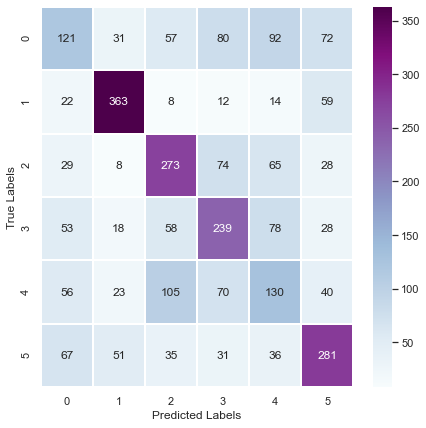

In [105]:
HetmapAndConf(LogisticRegression(max_iter=30) , X_train_std , y_train , X_test_std, y_test)

Training Accuracy : 0.567738487574597
Testing Accuracy : 0.524759529747061

              precision    recall  f1-score   support

         0.0       0.40      0.26      0.32       453
         1.0       0.71      0.81      0.75       478
         2.0       0.50      0.60      0.55       477
         3.0       0.48      0.61      0.53       474
         4.0       0.33      0.18      0.23       424
         5.0       0.57      0.63      0.60       501

    accuracy                           0.52      2807
   macro avg       0.50      0.52      0.50      2807
weighted avg       0.50      0.52      0.51      2807



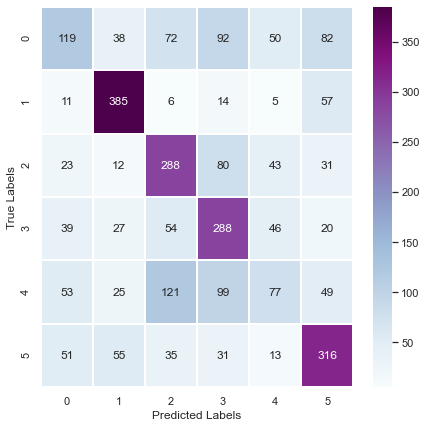

In [106]:
HetmapAndConf(LogisticRegression(max_iter=15) , X_train_std , y_train , X_test_std, y_test)

Training Accuracy : 0.5536652712211633
Testing Accuracy : 0.5365158532240827

              precision    recall  f1-score   support

         0.0       0.45      0.30      0.36       453
         1.0       0.70      0.80      0.75       478
         2.0       0.52      0.63      0.57       477
         3.0       0.48      0.64      0.55       474
         4.0       0.36      0.16      0.22       424
         5.0       0.56      0.63      0.59       501

    accuracy                           0.54      2807
   macro avg       0.51      0.53      0.51      2807
weighted avg       0.52      0.54      0.51      2807



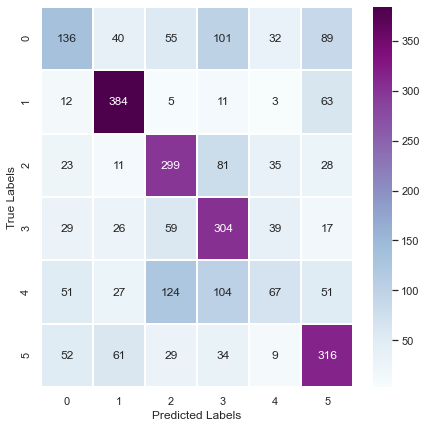

In [107]:
HetmapAndConf(LogisticRegression(max_iter=10) , X_train_std , y_train , X_test_std, y_test)

<font color="red">
Again there is confusion between buildings and mountains.<br>The other classifications are more focused and correct, but confusion is added between sea and glacier.<br>
This is a logical confusion as the prominent colors of the images are the same.<br><br>
Googeling Logistic Regression models taught us they tend to overfit the data, particularly in high-dimensional settings, that's explains are process for reducing the overfitting.
</font>

#### Third Model - SVM

As a general rule, SVM does not work on data with multiple classification classes, so working with it requires dividing the data into two classes again, where each time one class remains and the rest change to a new and different class.
That way it will be a binary classification problem and SVM can be run.
<br>sklearn's SVM knows how to deal with multiple classes, but initially we tried on our own to see what the result of such manual activation was.
<br>Since the data is basically balanced, and we converted all the data except the buildings to be in one class, we received data that is not balanced at all.
<br>Therefore the use of SVM led to the following results when most of the data was classified as 0 and the model failed to learn when to classify as 1.

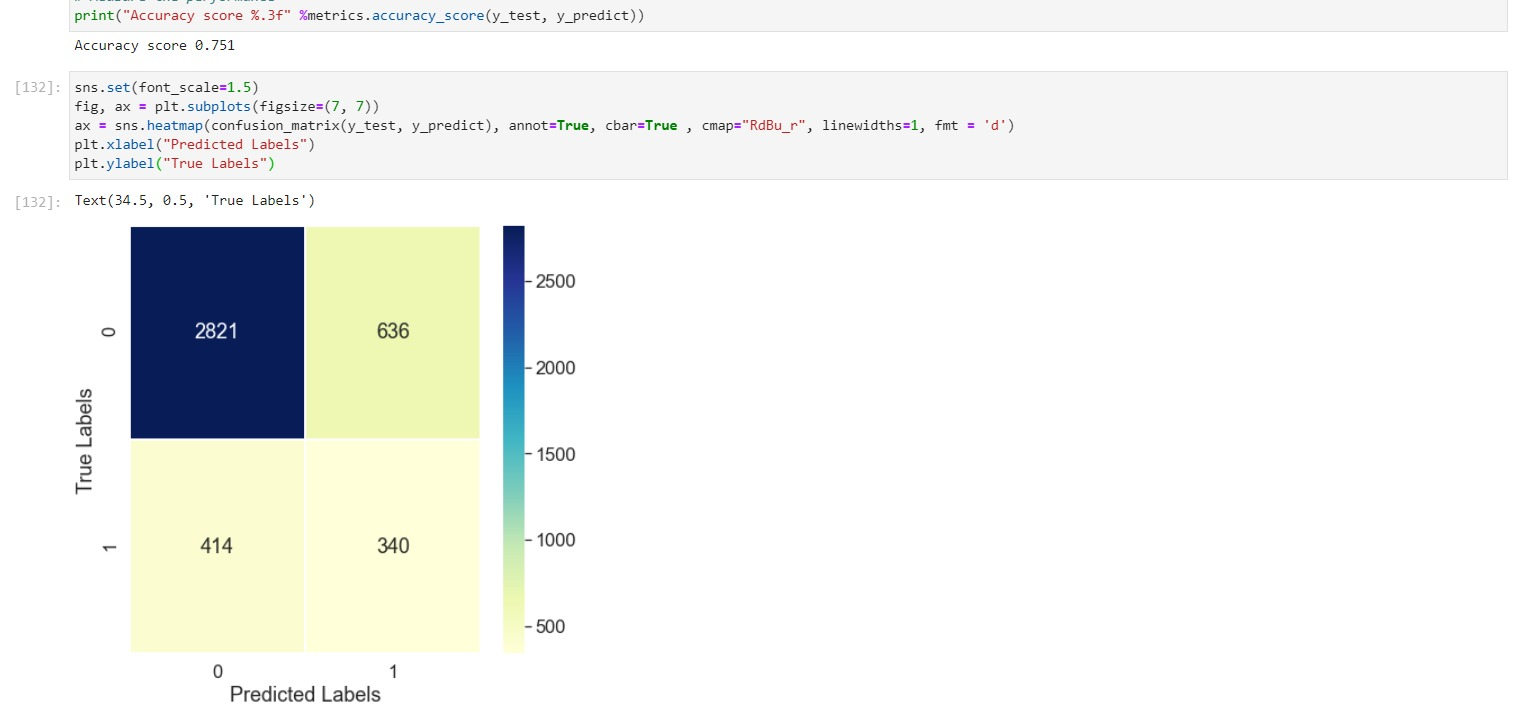

##### using kernel = 'linear'

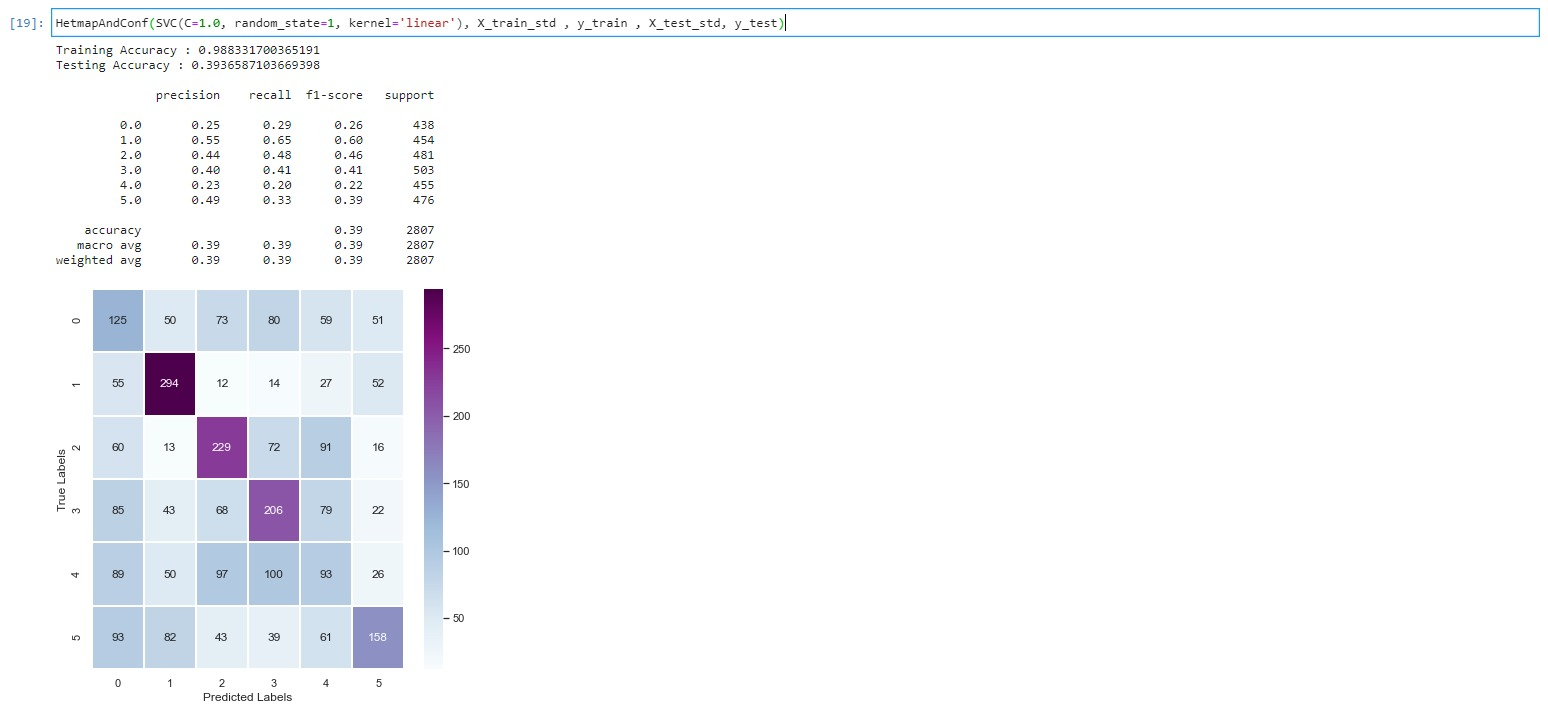

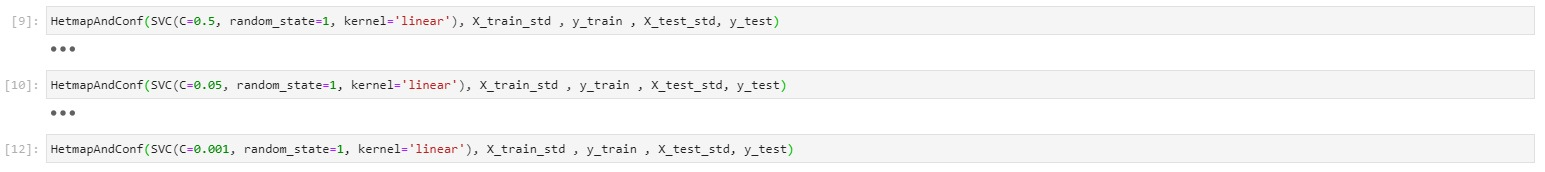

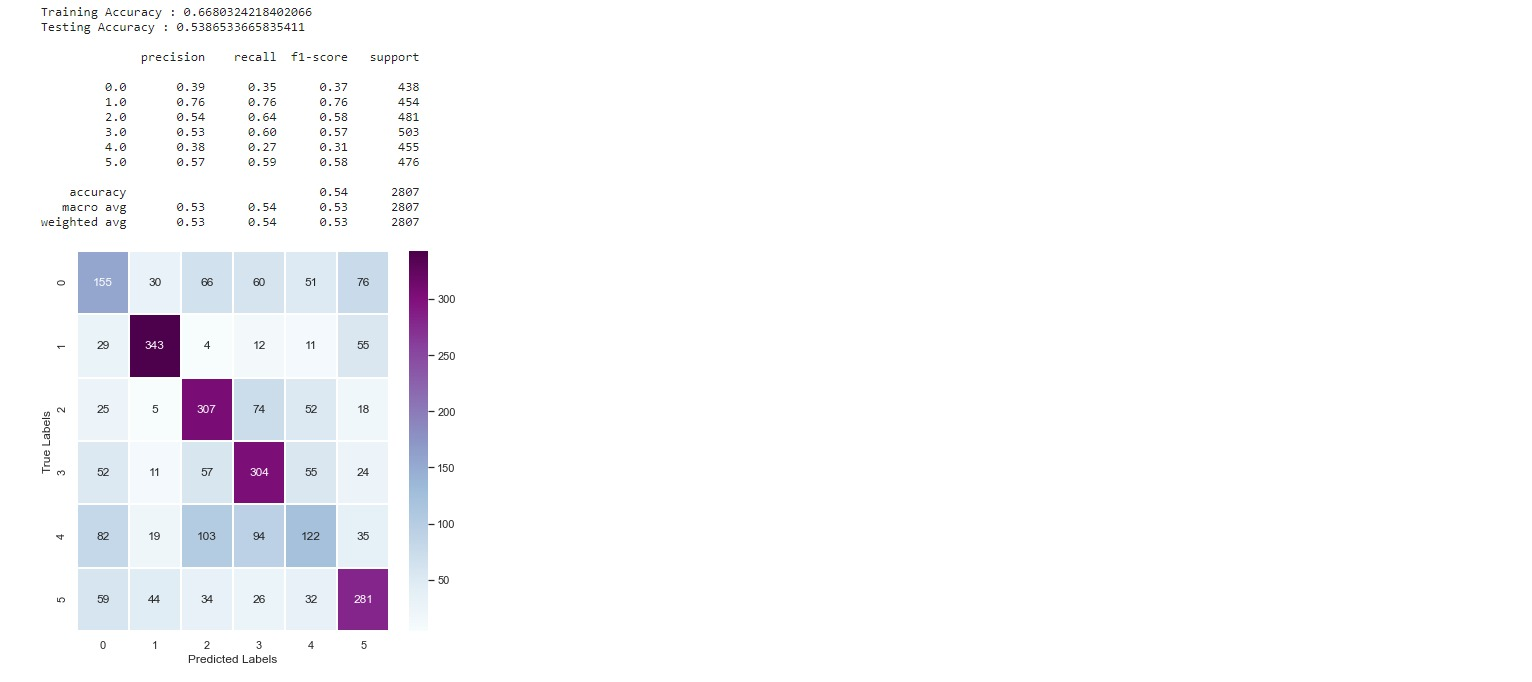

reducing 'C' value helped to avoid overfitting.

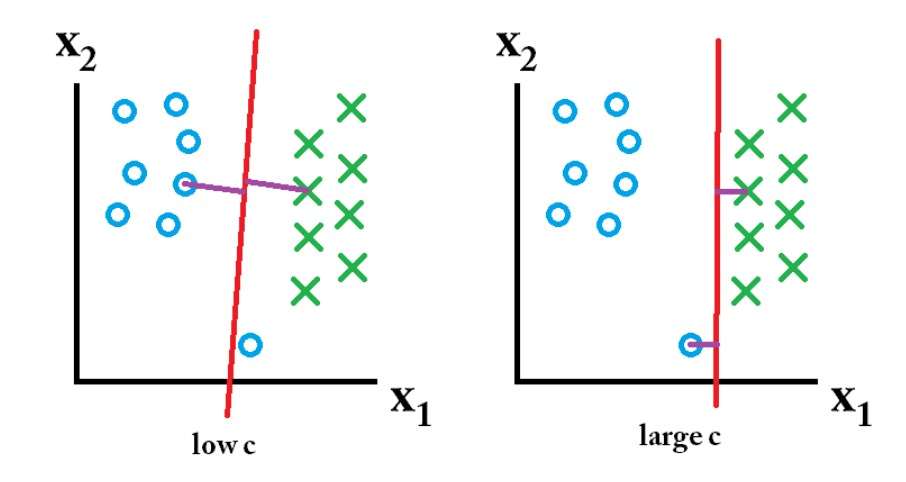

The parameter that decides how much weight each mistake will have, what is the penalty for wrong classification.<br>
We wanted the model to consider extreme examples as little as possible.<br><br>
<font color='red'>
We wondered why the accuracy percentages of KNN are less than SVM since in both at the moment the usage is linear.<br>
Searching for information on the comparison between the two models gave us results according to which KNN is better when the train set is large in relation to the number of features, while SVM will be suitable when the number of features is large in relation to the data.<br>
Since we have a very large number of features, we assume that this explanation adds to the results we received.<br><br>
The model connects the confusions of sea and classifies it as a mountain, sea and glacier.<br>
We noticed that the classification of sea is always less good, our assumption is that because the colors of the sea are similar to a glacier, and a glacier is similar to a mountain, together with a sky that everyone has, this constant confusion is created.</font>

##### using kernel = 'poly'

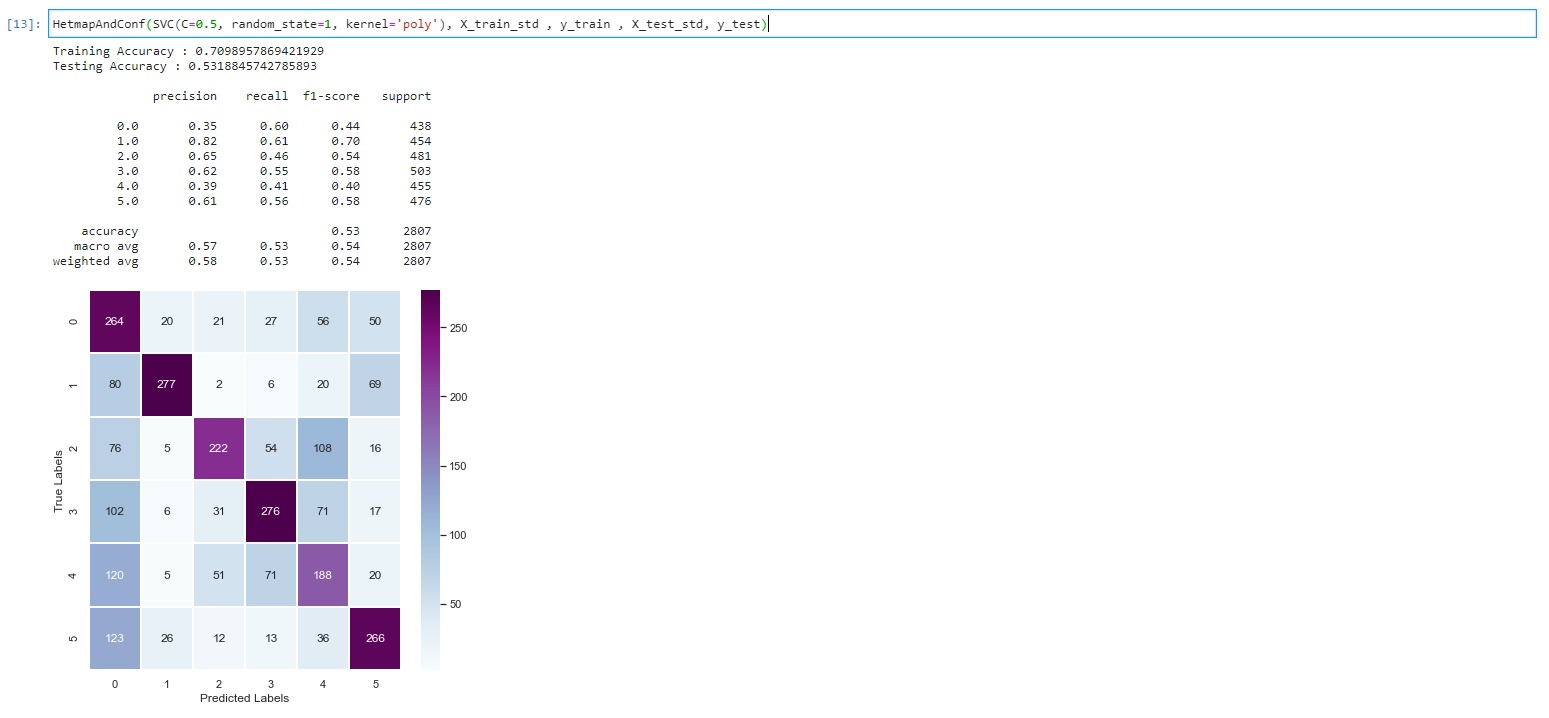

<font color="red">
The model is more accurate with 'poly' kernel because now the data fits better with it.<br>
Therefore, the negation of the classifications becomes very clear, but on the other hand, the error increases in several classes.<br>
More classes are confused with buildings.<br>
In our opinion it is because the negation has become clearer and there is a significant reduction in the dispersion into many different classifications.
</font>

##### using kernel = 'rbf'

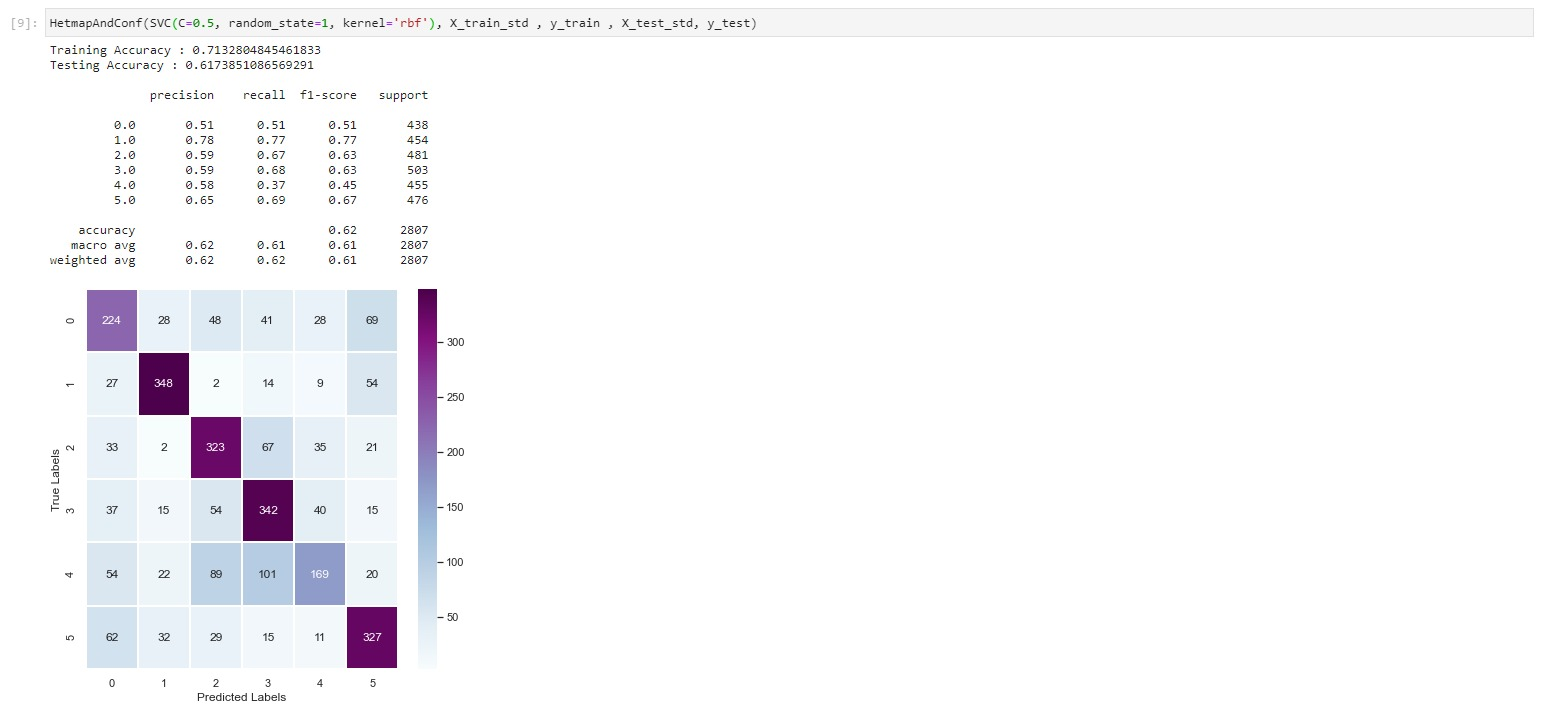

<font color='red'>
The appropriate kernel in the analysis for our data is 'rbf' since our data is neither linear nor polynomial.<br>
The data consists of many features, so looking at the dimensions will be different and more complex than the simple kernels, which is the reason for the results we got.</font>
<br><br>
We got the best accuracy so far, so we also tried the data in black and white tones.

Training Accuracy : 0.6459428164246904
Testing Accuracy : 0.535090844317777

              precision    recall  f1-score   support

         0.0       0.50      0.45      0.48       437
         1.0       0.57      0.74      0.64       459
         2.0       0.47      0.52      0.49       476
         3.0       0.56      0.60      0.58       489
         4.0       0.44      0.31      0.37       440
         5.0       0.63      0.56      0.60       506

    accuracy                           0.54      2807
   macro avg       0.53      0.53      0.53      2807
weighted avg       0.53      0.54      0.53      2807



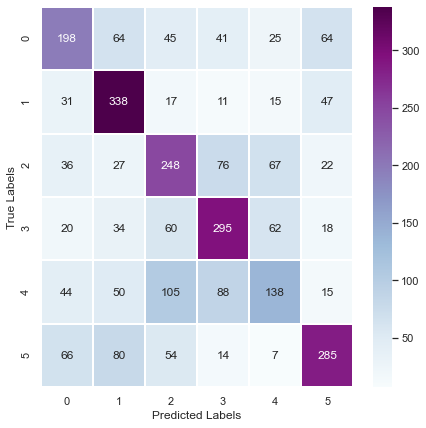

In [18]:
HetmapAndConf(SVC(C=0.5, random_state=1, kernel='rbf'), X_train_g_std , y_train_g , X_test_g_std, y_test_g)

Here there is confusion between the glaciers and the mountains as we expected.

#### Fourth Model - Decision Tree

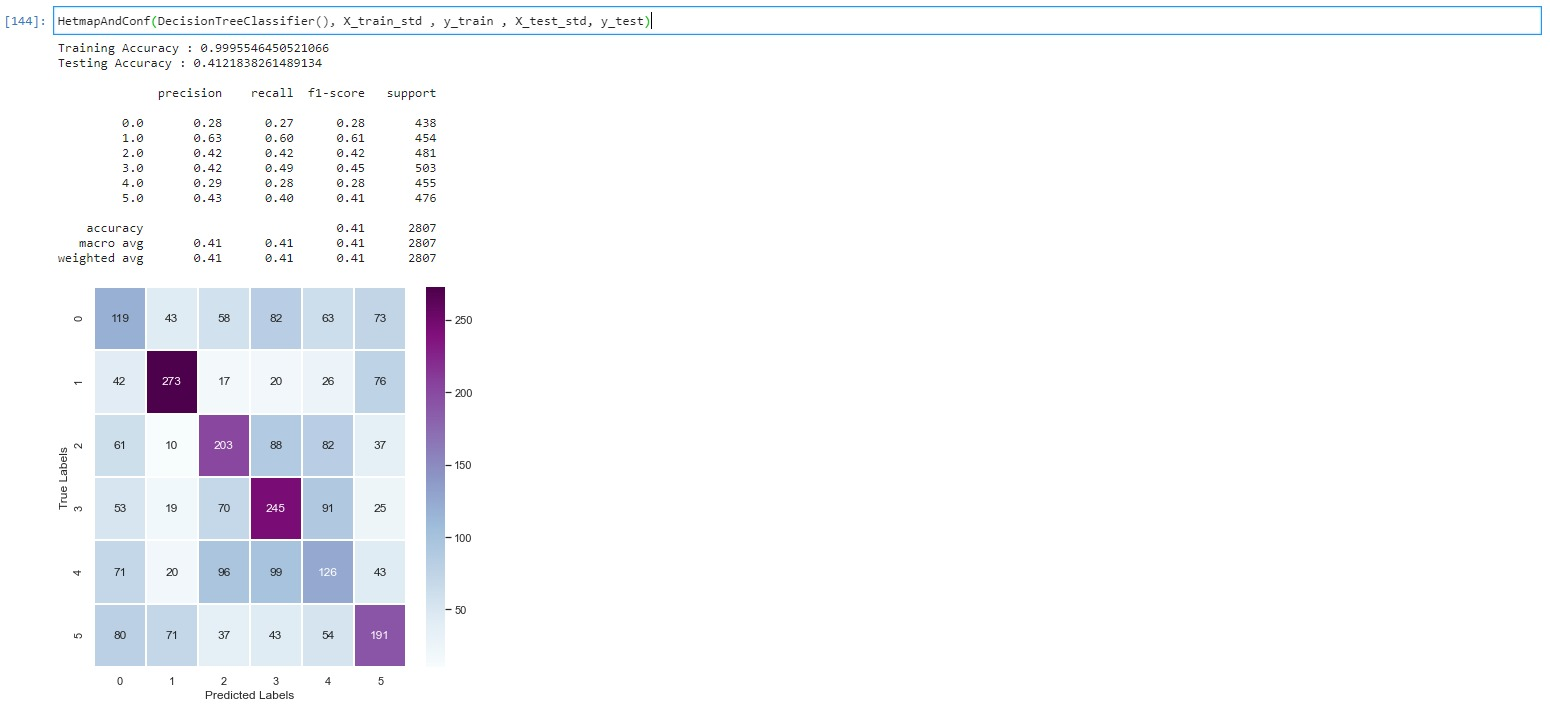

Since here too we got a high overfitting, we activated a Grid Search in order to get the right parameters for the best accuracy we would get.

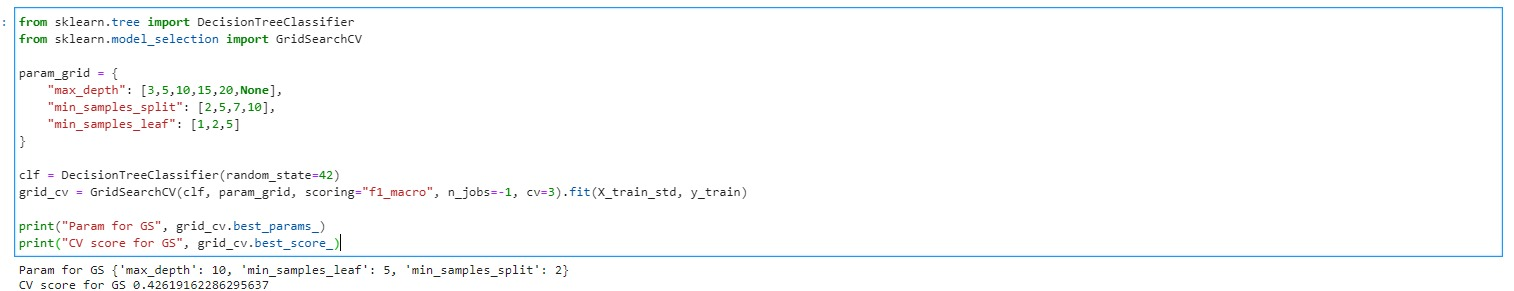

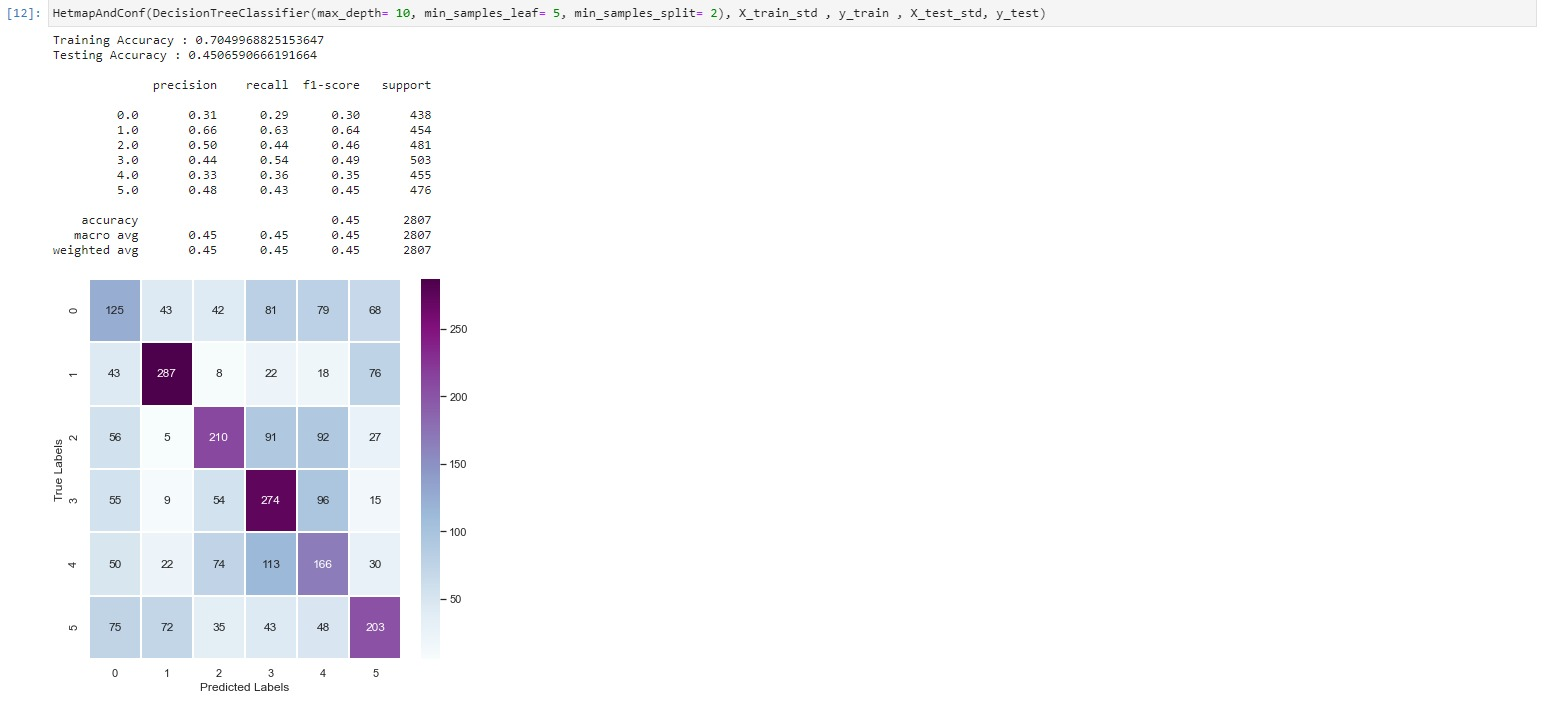

Overfitting did decrease but is still high, and accuracy improved somewhat.<br><br>
<font color="red">
We returned to a result similar to KNN in the confusions between the classes.<br>
It can be assumed that the questions asked in the Decision Tree model are related to the distance of the images from each other, but this is only a hypothesis and it is not based on an experiment.<br><br><br>
We saw in all the models confusion in the classification of sea.<br>
It should be noted that in the forest class there is almost no confusion in all the models we have seen so far.<br>
That is, the best classifications attributed to the forest.<br>
The phenomenon can be explained by the fact that these are the most unusual photos, that is, their color is different and the type of landscape in them is unlike any other landscape.<br>
This is probably the reason that when receiving an image of forest, the model manages to identify the connection to the forest class.
</font>

#### Fifth Model - Neural Network

In [10]:
X_color = df_color.drop('label', axis=1)
y_color = df_color.label

# split the data into train and test sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_color, y_color, test_size=0.2, random_state=4)

In [11]:
reshaped_X_train_c = X_train_c.to_numpy().reshape((11227, 150, 150, 3))

In [12]:
reshaped_X_test_c = X_test_c.to_numpy().reshape((2807, 150, 150, 3))

The first neural network is shallow.

In [168]:
input_shape = (150, 150, 3)

model = Sequential()

model.add( Conv2D(16, kernel_size=(3,3), strides=(4,4), activation='relu', input_shape= input_shape) )
model.add( MaxPool2D(pool_size=(2,2),strides=(1,1)) )

model.add( Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu') )
model.add( MaxPool2D(pool_size=(2,2),strides=(1,1)) )

model.add( Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu') )
model.add( MaxPool2D(pool_size=(2,2),strides=(1,1)) )

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 37, 37, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(reshaped_X_train_c, y_train_c, epochs=10, 
                    validation_data=(reshaped_X_test_c, y_test_c))

Epoch 1/10
351/351 [==============================] - 40s 111ms/step - loss: 10.2705 - accuracy: 0.3641 - val_loss: 1.3810 - val_accuracy: 0.4678
Epoch 2/10
351/351 [==============================] - 40s 113ms/step - loss: 1.3250 - accuracy: 0.4893 - val_loss: 1.2348 - val_accuracy: 0.5151
Epoch 3/10
351/351 [==============================] - 39s 113ms/step - loss: 1.1224 - accuracy: 0.5603 - val_loss: 1.2930 - val_accuracy: 0.5109
Epoch 4/10
351/351 [==============================] - 44s 126ms/step - loss: 1.0164 - accuracy: 0.5988 - val_loss: 1.2247 - val_accuracy: 0.5290
Epoch 5/10
351/351 [==============================] - 43s 122ms/step - loss: 0.8601 - accuracy: 0.6652 - val_loss: 1.2380 - val_accuracy: 0.5408
Epoch 6/10
351/351 [==============================] - 44s 126ms/step - loss: 0.7231 - accuracy: 0.7143 - val_loss: 1.4165 - val_accuracy: 0.5753
Epoch 7/10
351/351 [==============================] - 45s 127ms/step - loss: 0.6103 - accuracy: 0.7653 - val_loss: 1.4062 - val_a

88/88 - 2s - loss: 1.6101 - accuracy: 0.5743 - 2s/epoch - 19ms/step


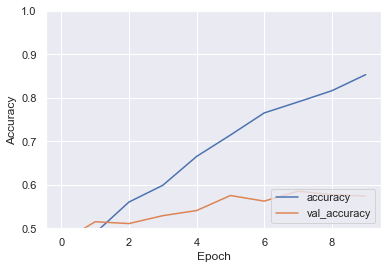

In [174]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(reshaped_X_test_c,  y_test, verbose=2)

The second neural network is deep.

In [13]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 128)      512       
 hNormalization)                                                 
                                                        

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(reshaped_X_train_c, y_train_c, epochs=10, 
                    validation_data=(reshaped_X_test_c, y_test_c))

Epoch 1/10
351/351 [==============================] - 896s 3s/step - loss: 1.1884 - accuracy: 0.6112 - val_loss: 2.0103 - val_accuracy: 0.4410
Epoch 2/10
351/351 [==============================] - 934s 3s/step - loss: 0.7626 - accuracy: 0.7313 - val_loss: 0.9775 - val_accuracy: 0.6584
Epoch 3/10
351/351 [==============================] - 943s 3s/step - loss: 0.5982 - accuracy: 0.7853 - val_loss: 1.2075 - val_accuracy: 0.6006
Epoch 4/10
351/351 [==============================] - 939s 3s/step - loss: 0.5290 - accuracy: 0.8074 - val_loss: 1.1278 - val_accuracy: 0.5803
Epoch 5/10
351/351 [==============================] - 942s 3s/step - loss: 0.4661 - accuracy: 0.8324 - val_loss: 0.9717 - val_accuracy: 0.6787
Epoch 6/10
351/351 [==============================] - 943s 3s/step - loss: 0.4195 - accuracy: 0.8486 - val_loss: 0.9173 - val_accuracy: 0.6826
Epoch 7/10
351/351 [==============================] - 1016s 3s/step - loss: 0.3744 - accuracy: 0.8651 - val_loss: 0.6514 - val_accuracy: 0.762

88/88 - 42s - loss: 1.1876 - accuracy: 0.6477 - 42s/epoch - 482ms/step


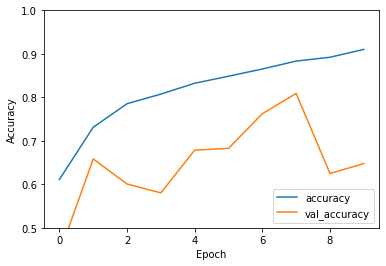

In [17]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(reshaped_X_test_c,  y_test_c, verbose=2)

Our assumption is that too deep learning leads to overfitting, so the run was only performed up to 10 iterations.
<br>The first mesh was shallow and got lower accuracy, but when running a deep mesh we had to truncate the number of iterations to get the best accuracy.<br>
As can be seen from the graph of the deep model, that the model gets better and better until a number of iterations, from where it goes down because it reaches overfitting.

## Summery:

*Challenges in our data -*
1. Image data
2. multi class

*Problems we encountered along the way -*
1. Keeping the colors of the photos because they are very important to us
2. The SVM model works on a binary classifier
3. Multiple features

*The confrontation -*
1. Convert each image to RGB and save it as a single vector according to the correct values using ravel().
2. Manual experiment and finally using a function of the sklearn library that also works on multiclass.
3. We used PCA to save the critical values followed by average pooling to reduce the number of features. In some models we added a check on black and white data but we saw less good results. In addition, we reduced the number of shades from 256 to 10.

**About trying black and white data:**
<br>By reducing the number of features by using images in black and white tones, we expected less good results because the data consists of landscape images and therefore the main thing that differentiates between the classes is the color of the image. <br>For example, the difference between a mountain and a glacier is the brown color versus the white color. <br>We were indeed right in this assumption.

**About overfitting phenomenon:**
<br>We saw that the overfitting phenomenon repeated itself in all the models we ran on the data.
<br>Our hypothesis is that our data is classified mainly according to more general details, and as you go down to smaller details, their significance regarding the classification decreases.
<br>For example, horizon lines in the center of the image can show hills or a mountain, but not a street, building or forest that will be expressed by vertical lines. <br>These are general details that do not require relatively much learning to identify them.
<br>Precisely when you go down to lower resolutions, for example a stone or a bird, they are not relevant to the general classification because they can appear in any of the categories.
<br>Therefore, when the learning was too specific, overfitting was done, and to avoid this we had to stop the learning at an early stage or make the model learn slowly.
<br>Therefore, when running SVM, we reduced the parameter C so that each example would have a very small effect on the learning.

<br>

It can clearly can be seen that the accuracies are not very high, we speculate that the phenomenon happens because of two motives:
* The images are not necessarily classified uniformly.<br>That is, a picture of a seashell is considered the sea even though it will not be similar at all to the other pictures in the same category.
* There are 6 categories, so our accuracy also shows a good learning of the data,<br>because a dummy classifier would have brought an accuracy of around 16%.


##### The best model without neural networks was SVM with rbf kernel with 61% accuracy.
##### The deep neural network was the best with 76% accuracy on the test after 7 iterations.